 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [02/Oct/2023 01:30:57] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/Oct/2023 01:31:04] "GET /docs/ HTTP/1.1" 200 -
127.0.0.1 - - [02/Oct/2023 01:31:04] "GET /flasgger_static/swagger-ui.css HTTP/1.1" 304 -
127.0.0.1 - - [02/Oct/2023 01:31:04] "GET /flasgger_static/swagger-ui-bundle.js HTTP/1.1" 304 -
127.0.0.1 - - [02/Oct/2023 01:31:04] "GET /flasgger_static/swagger-ui-standalone-preset.js HTTP/1.1" 304 -
127.0.0.1 - - [02/Oct/2023 01:31:04] "GET /flasgger_static/lib/jquery.min.js HTTP/1.1" 304 -
127.0.0.1 - - [02/Oct/2023 01:31:04] "GET /docs.json HTTP/1.1" 200 -
127.0.0.1 - - [02/Oct/2023 01:35:54] "POST /text-processing HTTP/1.1" 200 -
C:\Users\ghifa\CoDe\ENV\chal\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ghifa\CoDe\ENV\cha

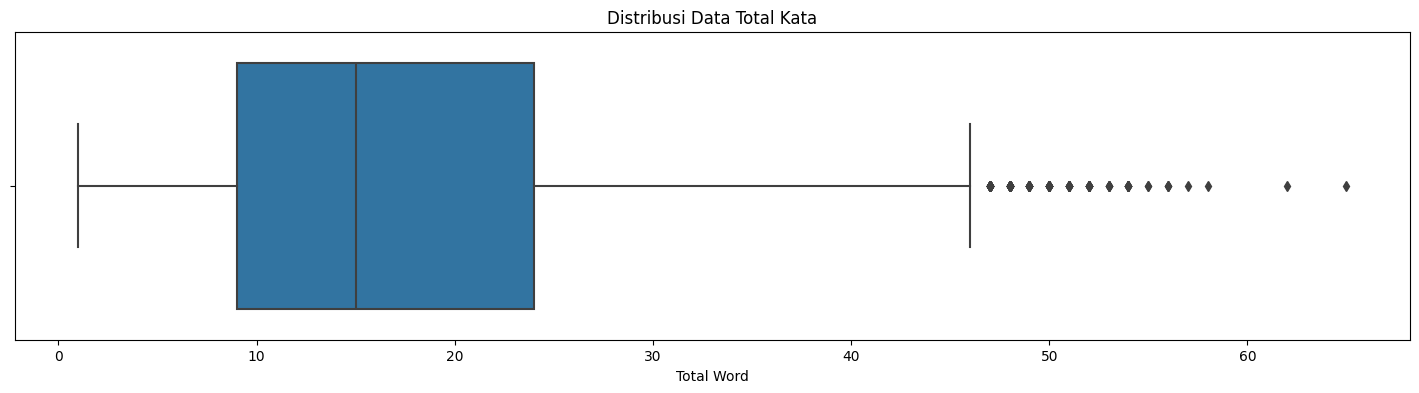

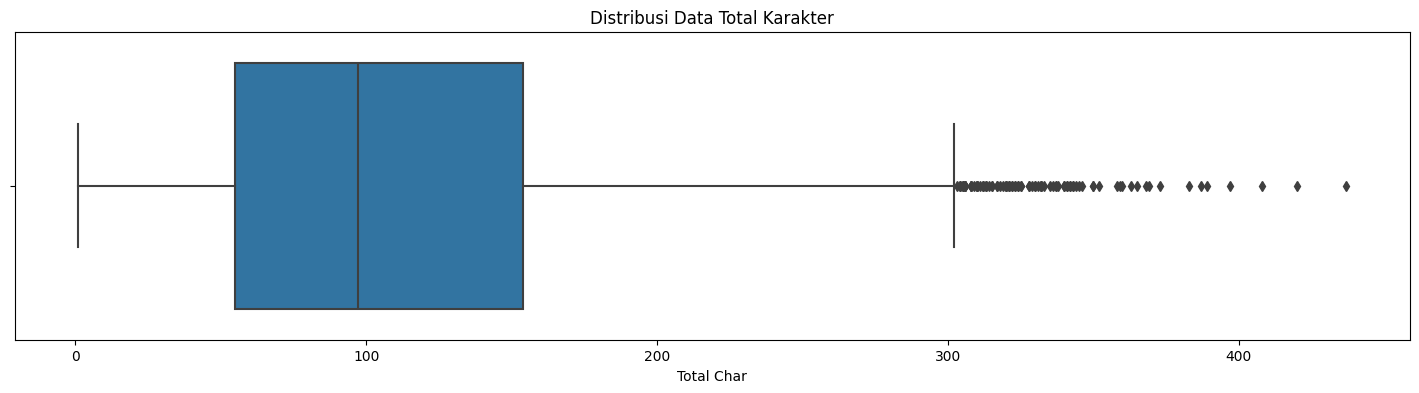

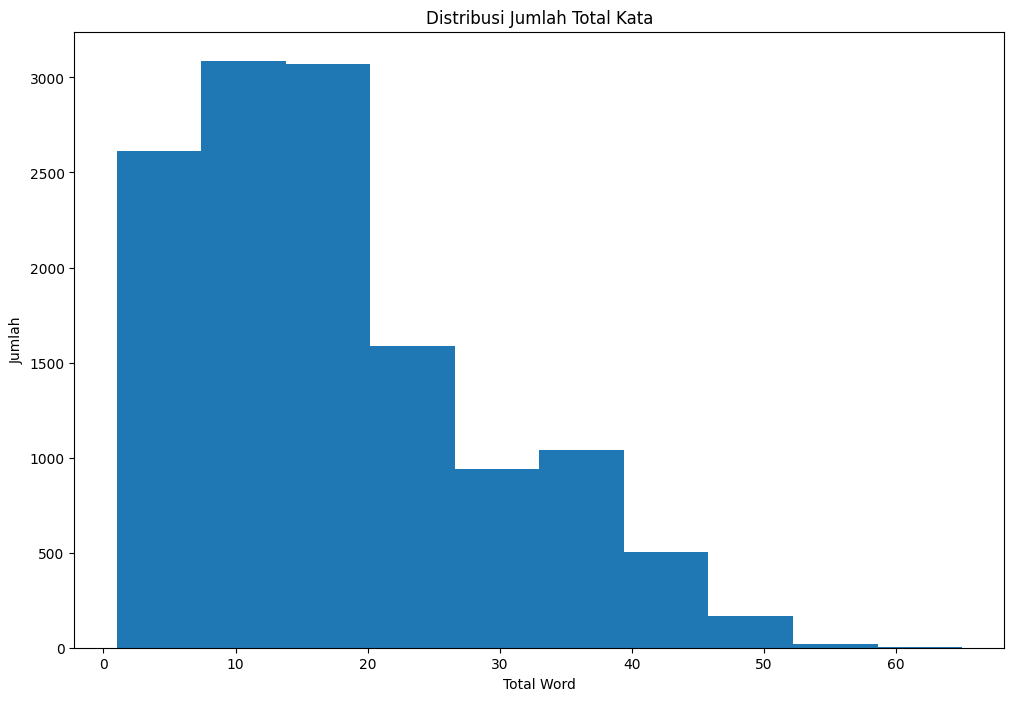

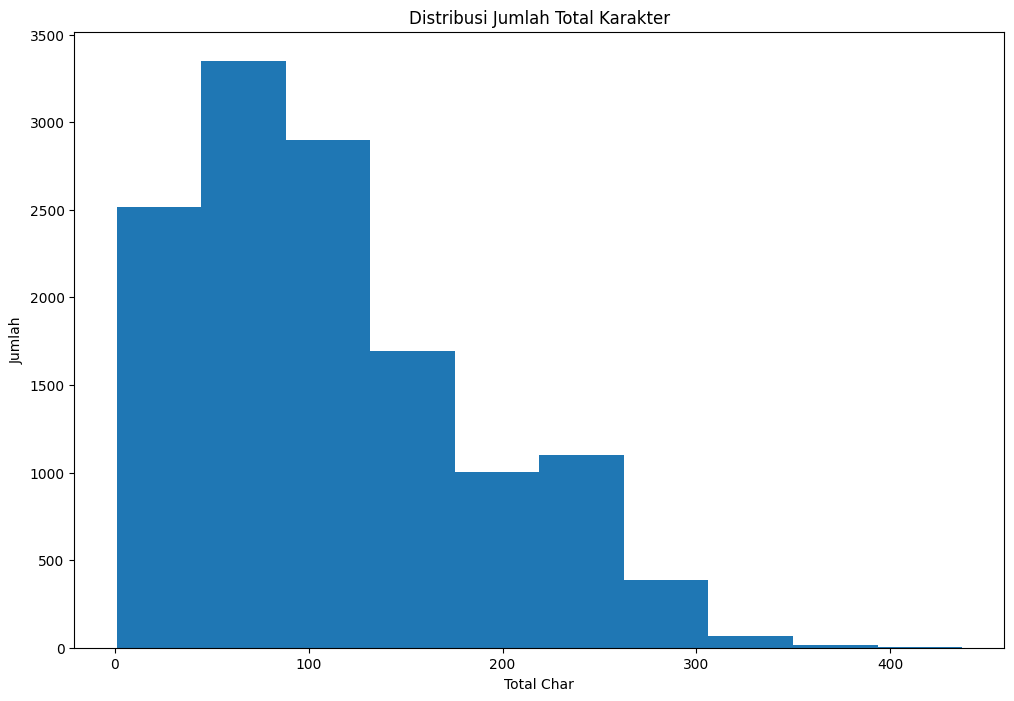

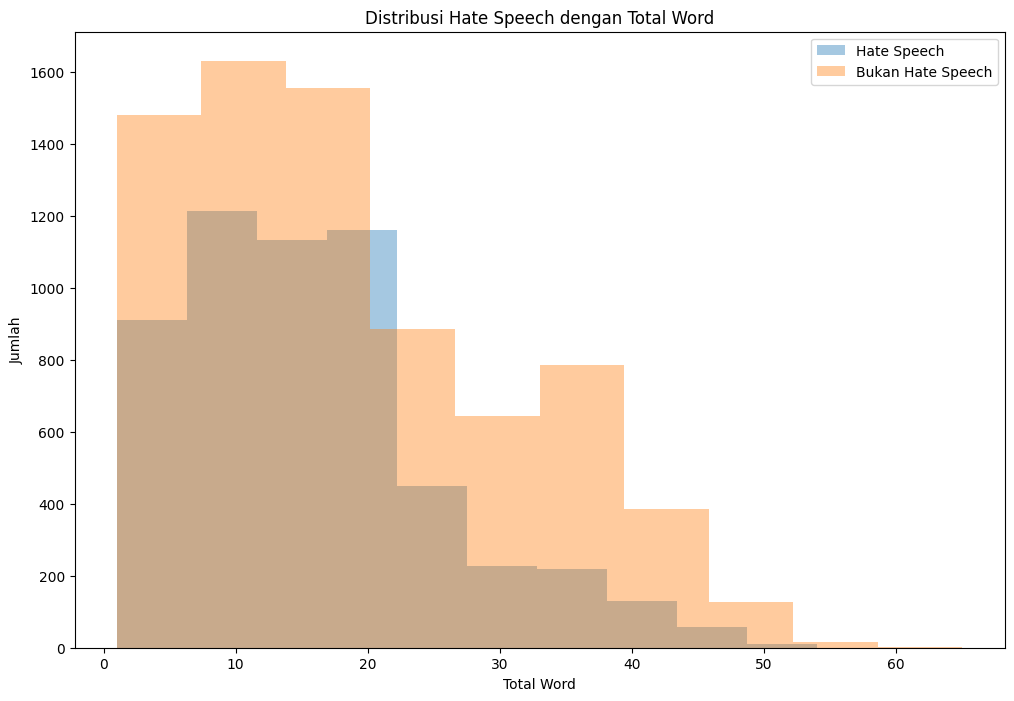

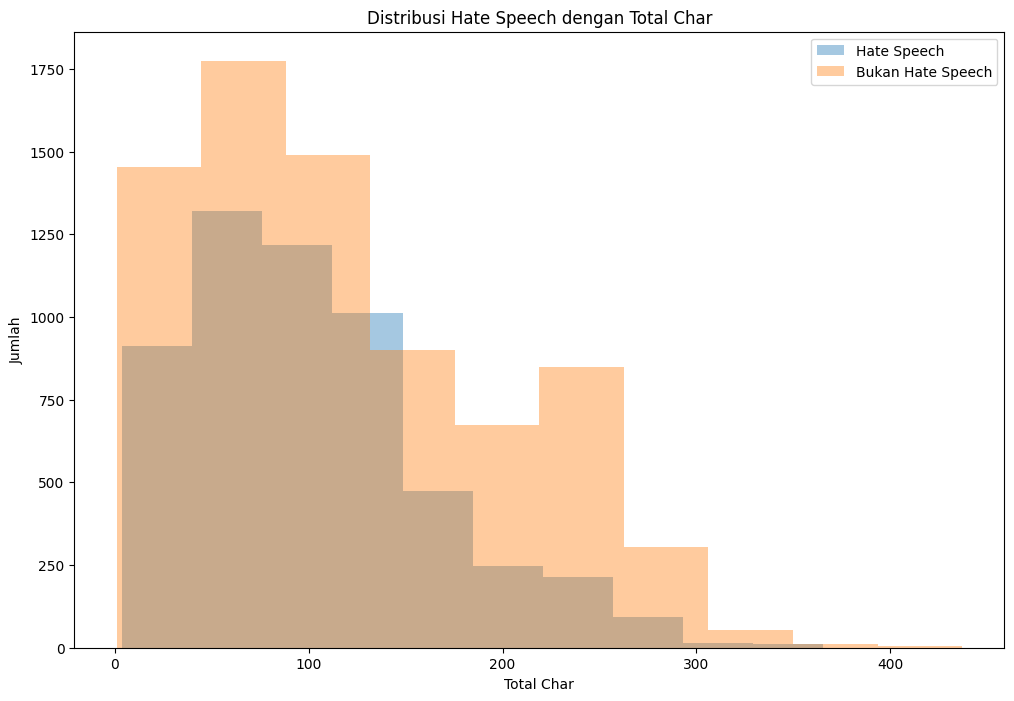

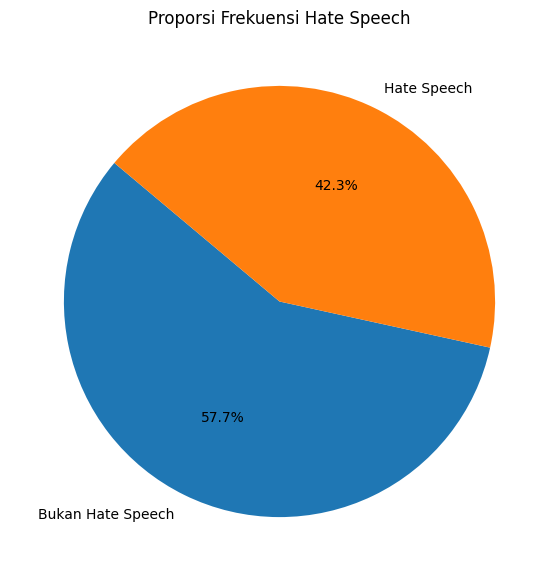

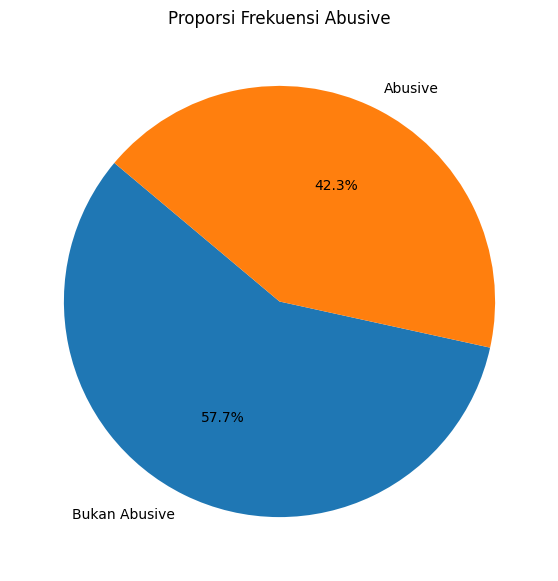

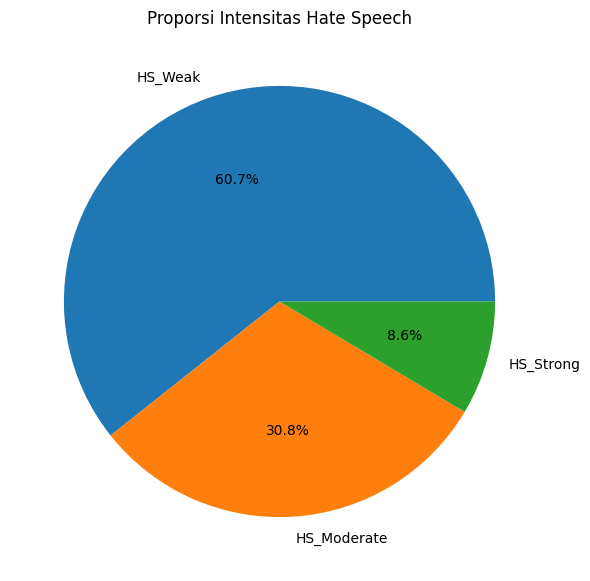

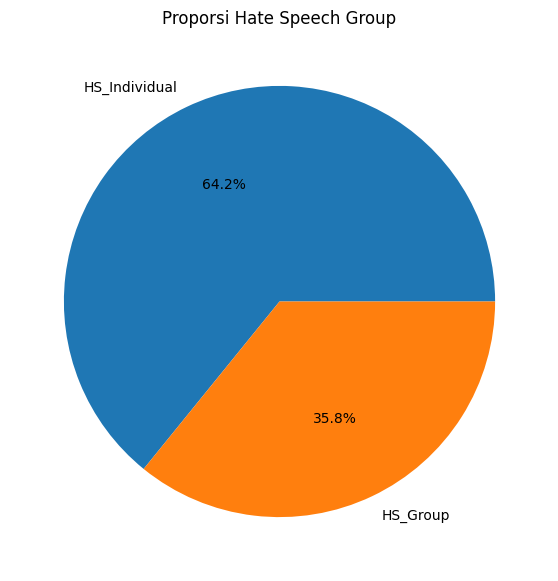

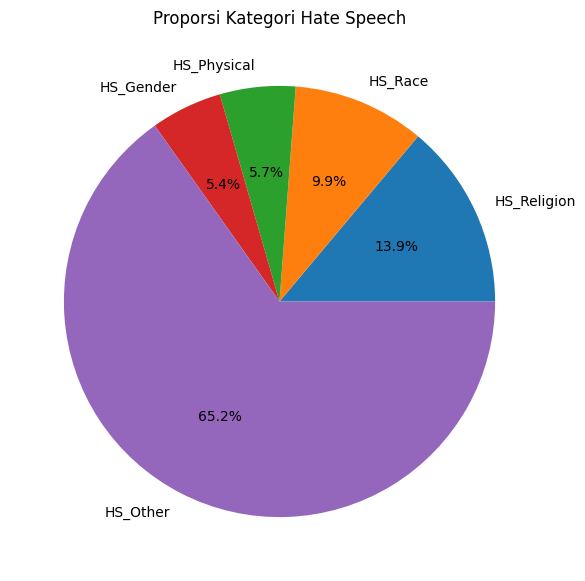

<Figure size 1800x1200 with 0 Axes>

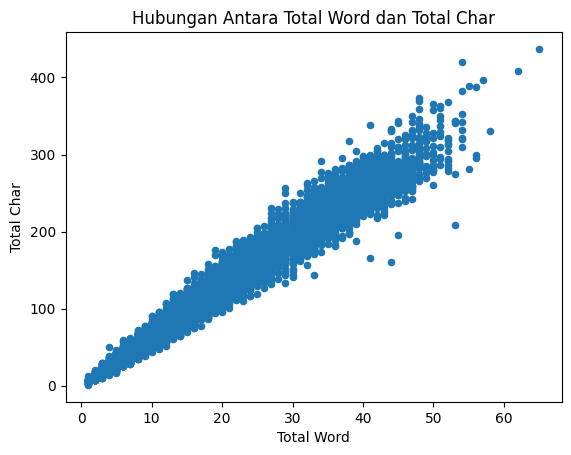

In [1]:
# PACKAGE
import pandas as pd
import re
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from flask import request, Flask, jsonify
from flasgger import Swagger, LazyString, LazyJSONEncoder, swag_from

# DEFINING TEXT CLEANSING
def text_cleansing(text):
    text = text.lower() #lowercase
    text = text.strip() #menghapus spasi di awal dan akhir
    text = re.sub(r'\buser\b|\brt\b|\bamp\b|(\bx[\da-f]{2})', ' ', text, flags=re.IGNORECASE)
    text = re.sub(r'\n', ' ', text, flags=re.IGNORECASE)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text)
    text = re.sub(r'(.)\1\1+', r'\1', text) #menghapus karakter berulang
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) #menghapus karakter non-alpanumerik
    text = re.sub(r'[øùºðµ¹ª³]', '', text, flags=re.IGNORECASE)
    text = re.sub(r'â', 'a', text, flags=re.IGNORECASE)
    text = re.sub(r'\s+', ' ', text).strip() #menghapus spasi berlebih dan mengganti dengan satu spasi
    text = re.sub(r'^\s+$', '', text) #menghapus seluruh kalimat yg hanya berisi spasi
    return text

# df_kamus AS A DICT
df_kamus = pd.read_csv("new_kamusalay.csv", encoding="latin-1", header=None)
df_kamus_map = dict(zip(df_kamus[0], df_kamus[1]))
def normalize(text):
    return ' '.join([df_kamus_map[word] if word in df_kamus_map else word for word in text.split(' ')])

# APPLY TEXT CLEANSING AND DICT
def preprocess_apply(text):
    text = text_cleansing(text)
    text = normalize(text)
    return text

# READ abusive.csv
df_abusive = pd.read_csv("abusive.csv")
# CREATE A FUNCTION TO COUNT NUMBER OF ABUSIVE WORDS FOUND IN A CLEANED TWEET
def count_abusive(x):
    text = x
    matched_list = []
    for i in range(len(df_abusive)):
        for j in x.split():
            word = df_abusive['ABUSIVE'].iloc[i]
            if word==j:
                matched_list.append(word)
    return len(matched_list)

# SWAGGER UI
app = Flask(__name__)

app.json_encoder = LazyJSONEncoder
swagger_template = dict(
info = {
    'title': LazyString(lambda: 'API Documentation for Data Processing and Modeling'),
    'version': LazyString(lambda: '1.0.0'),
    'description': LazyString(lambda: 'Dokumentasi API untuk Data Processing and Modeling')
    },
    host = LazyString(lambda: request.host)
)

swagger_config = {
    "headers": [],
    "specs": [
        {
            "endpoint": 'docs',
            "route": '/docs.json'
        }
    ],
    "static_url_path": "/flasgger_static",
    "swagger_ui": True,
    "specs_route": "/docs/"
}
swagger = Swagger(app, template=swagger_template,
                 config=swagger_config)

@swag_from(r"C:\Users\ghifa\CoDe\Repo_Chal\docs\hello_world.yml", methods=['GET'])
@app.route('/', methods=['GET'])
def hello_world():
    json_response = {
        'status_code': 200,
        'description': "Menyapa Hello World",
        'data': "Hello World"
    }
    
    response_data = jsonify(json_response)
    return response_data

@swag_from(r"C:\Users\ghifa\CoDe\Repo_Chal\docs\text_processing.yml", methods=['POST'])
@app.route('/text-processing', methods=['POST'])
def text_processing():
    
    text = request.form.get('text')
    text = preprocess_apply(text)
    abusive = count_abusive(text)
    
    json_response = {
        'status_code': 200,
        'description': "Teks yang sudah bersih dan jumlah kata abusivenya",
        'data': (text, f"jumlah kata abusivenya: {abusive}")
    }
    
    response_data = jsonify(json_response)
    return response_data

@swag_from(r"C:\Users\ghifa\CoDe\Repo_Chal\docs\text_processing_file.yml", methods=['POST'])
@app.route('/text-processing-file', methods=['POST'])
def text_processing_file():
    global df, new_df
    
    filein = request.files.get('filein')
    df = pd.read_csv(filein,encoding="latin-1")
    pd.set_option('display.max_colwidth', None)
    
    new_df = df.copy()
    
#     DROP DATA DUPLICATE
    new_df = new_df.drop_duplicates()
    
#     APPLY TEXT CLEANSING TO DATAFRAME
    new_df['Cleaned'] = new_df.Tweet.apply(preprocess_apply)
    
#     ADD NEW COLUMN
    new_df['total_word'] = new_df.Cleaned.apply(lambda text: len(text.split(" ")))
    new_df['total_char'] = new_df.Cleaned.apply(len)
#     APPLY THE FUNCTION TO COUNT ABUSIVE WORDS, AND CREATE A NEW COLUMN BASED OFF OF IT
    new_df['abusive_word'] = new_df['Cleaned'].apply(lambda x: count_abusive(x))
    
#     MENGHAPUS BARIS DENGAN TOTAL CHAR = 0
    new_df = new_df[new_df['total_char']>0]
    
#     INSERT DATAFRAME TO DATABASE
    conn = sqlite3.connect('testing.db')
    query1 = """
    create table if not exists cleansing_tweet 
    (raw_tweet varchar(255), cleaned_tweet varchar(255), total_word int, total_char int, abusive_word int);
    """
    conn.execute(query1)
    
    for i in range(len(new_df)):
        tweet = new_df['Tweet'].iloc[i]
        cleaned = new_df['Cleaned'].iloc[i]
        word = new_df['total_word'].iloc[i]
        char = new_df['total_char'].iloc[i]
        abusive = new_df['abusive_word'].iloc[i]
        
        query2 = """
        insert into cleansing_tweet (raw_tweet, cleaned_tweet, total_word, total_char, abusive_word) 
        values (?, ?, ?, ?, ?)
        """
        conn.execute(query2, (tweet, cleaned, str(word), str(char), str(abusive)))
        conn.commit()
    conn.close()
    
#     OUTPUT JSON RESPONSE
    json_response = {
        'status_code': 200,
        'description': "File yang sudah diproses",
        'data': list(new_df['Cleaned'])
    }
    
#     VISUALIZE DATA AND EXPORT AS IMAGE
    plt.figure(figsize=(18,4))
    sns.boxplot(data=new_df, x='total_word')
    plt.title('Distribusi Data Total Kata')
    plt.xlabel('Total Word')
    plt.savefig('total_word_boxplot.jpeg')
    
    plt.figure(figsize=(18,4))
    sns.boxplot(data=new_df, x='total_char')
    plt.title('Distribusi Data Total Karakter')
    plt.xlabel('Total Char')
    plt.savefig('total_char_boxplot.jpeg')
    
    plt.figure(figsize=(12,8))
    plt.hist(x='total_word', data=new_df)
    plt.xlabel('Total Word')
    plt.ylabel('Jumlah')
    plt.title('Distribusi Jumlah Total Kata')
    plt.savefig('distribusi_total_word.jpeg')

    plt.figure(figsize=(12,8))
    plt.hist(x='total_char', data=new_df)
    plt.xlabel('Total Char')
    plt.ylabel('Jumlah')
    plt.title('Distribusi Jumlah Total Karakter')
    plt.savefig('distribusi_total_char.jpeg')

    HS = new_df['HS']==1
    no_HS = new_df['HS']==0
    plt.figure(figsize=(12,8))
    plt.hist(new_df.loc[HS,'total_word'], label='Hate Speech' , alpha=0.4)
    plt.hist(new_df.loc[no_HS,'total_word'], label='Bukan Hate Speech' , alpha=0.4)
    plt.legend()
    plt.ylabel("Jumlah")
    plt.xlabel("Total Word")
    plt.title("Distribusi Hate Speech dengan Total Word")
    plt.savefig("distribusi_hs_word.jpeg")

    HS = new_df['HS']==1
    no_HS = new_df['HS']==0
    plt.figure(figsize=(12,8))
    plt.hist(new_df.loc[HS,'total_char'], label='Hate Speech' , alpha=0.4)
    plt.hist(new_df.loc[no_HS,'total_char'], label='Bukan Hate Speech' , alpha=0.4)
    plt.legend()
    plt.ylabel("Jumlah")
    plt.xlabel("Total Char")
    plt.title("Distribusi Hate Speech dengan Total Char")
    plt.savefig("distribusi_hs_char.jpeg")
    
    absv = new_df['Abusive']==1
    no_absv = new_df['Abusive']==0
    plt.figure(figsize=(12,8))
    plt.hist(new_df.loc[absv,'total_word'], label='Abusive' , alpha=0.4)
    plt.hist(new_df.loc[no_absv,'total_word'], label='Bukan Abusive' , alpha=0.4)
    plt.legend()
    plt.ylabel("Jumlah")
    plt.xlabel("Total Word")
    plt.title("Distribusi Abusive dengan Total Word")
    plt.savefig("distribusi_abs_word.jpeg")

    HS_value_count = new_df['HS'].value_counts()
    plt.figure(figsize=(7,7))
    plt.pie(HS_value_count, labels=['Bukan Hate Speech', 'Hate Speech'], autopct='%1.1f%%', startangle=140)
    plt.title('Proporsi Frekuensi Hate Speech')
    plt.savefig("proporsi_frekuensi_hs.jpeg")
    
    abs_value_count = new_df['Abusive'].value_counts()
    plt.figure(figsize=(7,7))
    plt.pie(HS_value_count, labels=['Bukan Abusive', 'Abusive'], autopct='%1.1f%%', startangle=140)
    plt.title('Proporsi Frekuensi Abusive')
    plt.savefig("proporsi_frekuensi_abs.jpeg")
    
    categories = ['HS_Weak', 'HS_Moderate', 'HS_Strong']
    counts = [new_df[category].sum() for category in categories]
    plt.figure(figsize=(7,7))
    plt.pie(counts, labels=categories, autopct='%1.1f%%')
    plt.title('Proporsi Intensitas Hate Speech')
    plt.savefig("proporsi_hs_intens.jpeg")
    
    categories = ['HS_Individual', 'HS_Group']
    counts = [new_df[category].sum() for category in categories]
    plt.figure(figsize=(7,7))
    plt.pie(counts, labels=categories, autopct='%1.1f%%')
    plt.title('Proporsi Hate Speech Group')
    plt.savefig("proporsi_hs_group.jpeg")
    
    categories = ['HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other']
    counts = [new_df[category].sum() for category in categories]
    plt.figure(figsize=(7,7))
    plt.pie(counts, labels=categories, autopct='%1.1f%%')
    plt.title('Proporsi Kategori Hate Speech')
    plt.savefig("proporsi_hs_category.jpeg")
    
    plt.figure(figsize=(18,12))
    new_df.plot(x='total_word', y='total_char', kind='scatter')
    plt.xlabel('Total Word')
    plt.ylabel('Total Char')
    plt.title('Hubungan Antara Total Word dan Total Char')
    plt.savefig("hubungan_word_char.jpeg")
    
    
    response_data = jsonify(json_response)
    return response_data

if __name__ == '__main__':
    app.run()

In [2]:
new_df.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Cleaned,total_word,total_char,abusive_word
0,- disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego ! ! !',1,1,1,0,0,0,0,0,1,1,0,0,di saat semua cowok berusaha melacak perhatian gue kamu lantas remehkan perhatian yang gue kasih khusus ke kamu basic kamu cowok bego,22,133,1
1,RT USER: USER siapa yang telat ngasih tau elu?edan sarap gue bergaul dengan cigax jifla calis sama siapa noh licew juga',0,1,0,0,0,0,0,0,0,0,0,0,siapa yang telat memberi tau kamu edan sarap gue bergaul dengan cigax jifla calis sama siapa itu licew juga,19,107,2
2,"41. Kadang aku berfikir, kenapa aku tetap percaya pada Tuhan padahal aku selalu jatuh berkali-kali. Kadang aku merasa Tuhan itu ninggalkan aku sendirian. Ketika orangtuaku berencana berpisah, ketika kakakku lebih memilih jadi Kristen. Ketika aku anak ter",0,0,0,0,0,0,0,0,0,0,0,0,41 kadang aku berpikir kenapa aku tetap percaya pada tuhan padahal aku selalu jatuh berkali kali kadang aku merasa tuhan itu meninggalkan aku sendirian ketika orang tuaku berencana berpisah ketika kakakku lebih memilih jadi kristen ketika aku anak ter,39,251,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT TAPI DILIAT DARI MANA ITU AKU',0,0,0,0,0,0,0,0,0,0,0,0,aku itu aku dan ku tau matamu sipit tapi dilihat dari mana itu aku,14,66,1
4,USER USER Kaum cebong kapir udah keliatan dongoknya dari awal tambah dongok lagi hahahah',1,1,0,1,1,0,0,0,0,0,1,0,kaum cebong kafir sudah kelihatan dongoknya dari awal tambah dungu lagi haha,12,76,3


In [3]:
conn = sqlite3.connect('testing.db')
select_all = "select * from cleansing_tweet"
cursor = conn.execute(select_all)
all_rows = cursor.fetchall()
all_rows

[("- disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego ! ! !'",
  'di saat semua cowok berusaha melacak perhatian gue kamu lantas remehkan perhatian yang gue kasih khusus ke kamu basic kamu cowok bego',
  22,
  133,
  1),
 ("RT USER: USER siapa yang telat ngasih tau elu?edan sarap gue bergaul dengan cigax jifla calis sama siapa noh licew juga'",
  'siapa yang telat memberi tau kamu edan sarap gue bergaul dengan cigax jifla calis sama siapa itu licew juga',
  19,
  107,
  2),
 ('41. Kadang aku berfikir, kenapa aku tetap percaya pada Tuhan padahal aku selalu jatuh berkali-kali. Kadang aku merasa Tuhan itu ninggalkan aku sendirian. Ketika orangtuaku berencana berpisah, ketika kakakku lebih memilih jadi Kristen. Ketika aku anak ter',
  '41 kadang aku berpikir kenapa aku tetap percaya pada tuhan padahal aku selalu jatuh berkali kali kadang aku merasa tuhan itu meninggalkan aku sendirian ketika orang tuaku berenc

<h1>Univariate Analysis

In [4]:
new_df['total_word'].describe()

count    13031.000000
mean        17.573172
std         11.224275
min          1.000000
25%          9.000000
50%         15.000000
75%         24.000000
max         65.000000
Name: total_word, dtype: float64

In [5]:
new_df['total_char'].describe()

count    13031.000000
mean       112.166526
std         73.048862
min          1.000000
25%         55.000000
50%         97.000000
75%        154.000000
max        437.000000
Name: total_char, dtype: float64

<h2>Measures of Central Tendency

In [6]:
print("Total Word")
print("Mean = ", new_df['total_word'].mean())
print("Median = ", new_df['total_word'].median())
print("Modus = ", new_df['total_word'].mode())

Total Word
Mean =  17.57317166756197
Median =  15.0
Modus =  0    11
Name: total_word, dtype: int64


<h2>Measures of Spread

In [7]:
range_word = new_df.total_word.max()-new_df.total_word.min()
print("Range total_word = ", range_word)

Range total_word =  64


In [8]:
# cari nilai min
p0 = new_df.total_word.min()
# cari nilai max
p100 = new_df.total_word.max()

# cari q1
q1 = new_df.total_word.quantile(0.25)
# q2
q2 = new_df.total_word.quantile(0.5)
# q3
q3 = new_df.total_word.quantile(0.75)

# cari IQR
iqr = q3-q1

# cari batas bawah
lower_limit = q1-1.5*iqr
# batas atas
upper_limit = q3+1.5*iqr

print("Total Word")
print("Batas Bawah 'total_word': ", lower_limit)
print("Nilai Minimum: ", p0)

if lower_limit < p0:
  print("Tidak ada outlier dari sisi batas bawah")
else:
  print("ada outlier dari sisi batas bawah")

print()
print("Batas Atas 'total_word':", upper_limit)
print("Nilai Maximum:", p100)

if upper_limit > p100:
  print("Tidak ada outlier dari sisi batas atas")
else:
  print("ada outlier dari sisi batas atas")

Total Word
Batas Bawah 'total_word':  -13.5
Nilai Minimum:  1
Tidak ada outlier dari sisi batas bawah

Batas Atas 'total_word': 46.5
Nilai Maximum: 65
ada outlier dari sisi batas atas


In [9]:
mean = new_df['total_word'].mean()
var = new_df['total_word'].var()
std = new_df['total_word'].std()

print("Total Word")
print("Mean = ", mean)

print()
print("Variance = ", var)
if var == mean:
    print("Nilai total_word tidak menjauhi Mean")
else:
    print("Nilai total_word menjauhi Mean")

print()
print("Standart Deviation = ", std)
if std == mean:
    print("Nilai total_word tidak menjauhi Mean")
else:
    print("Nilai total_word menjauhi Mean")

Total Word
Mean =  17.57317166756197

Variance =  125.98434234957635
Nilai total_word menjauhi Mean

Standart Deviation =  11.224274691470107
Nilai total_word menjauhi Mean


<h2>Measures to Describe Shape of Distribution

In [10]:
skew = new_df['total_word'].skew()
kurtosis = new_df['total_word'].kurtosis()

print("Total Word")
print()
print("Skewness = ", skew)
if skew == 0:
    print("Data terdistribusi normal")
elif skew < 0:
    print("Skewness bernilai negatif")
else:
    print("Skewness bernilai positif")

print()
print("Kurtosis = ", kurtosis)
if kurtosis == 3:
    print("Mesokurtic yaitu Data terdistribusi normal")
elif kurtosis < 3:
    print("Platykurtic yaitu cenderung menghasilkan lebih sedikit nilai outlier")
else:
    print("Leptokurtic yaitu cenderung menghasilkan lebih banyak nilai outlier")

Total Word

Skewness =  0.8169239993052878
Skewness bernilai positif

Kurtosis =  -0.037570407732200106
Platykurtic yaitu cenderung menghasilkan lebih sedikit nilai outlier


<h1>Bivariate Analysis

In [11]:
new_df['total_word'].corr(new_df['total_char'])

0.9845641619904404

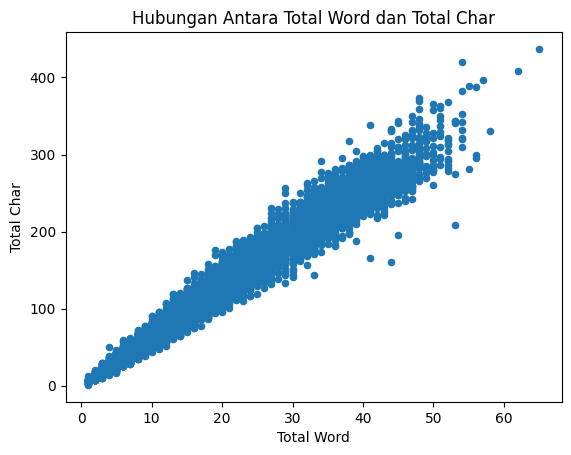

In [12]:
new_df.plot(x='total_word', y='total_char', kind='scatter')
plt.xlabel('Total Word')
plt.ylabel('Total Char')
plt.title('Hubungan Antara Total Word dan Total Char')
plt.show()